In [0]:
from pyspark.sql.types import *
import pyspark.sql.functions as f
import os,time
from pyspark import SparkContext
from pyspark.sql import SparkSession
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()
sc = spark.sparkContext

%md
# Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_demographic.parquet")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: string (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: integer (nullable = true)
 |-- net_worth: integer (nullable = true)
 |-- education_highest: integer (nullable = true)
 |-- gender_individual: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,education_highest,gender_individual
00000015,2,2,1,S,B,S,O,5,5,6,4,M
00000028,3,2,2,S,W,S,O,3,8,5,2,M
00000056,2,2,1,S,W,S,O,4,10,5,1,M
00000061,2,2,2,M,W,S,O,15,8,8,1,M
00000098,3,2,2,M,W,S,O,4,13,7,1,F
00000111,2,2,1,S,W,S,O,15,4,8,2,M
00000122,3,2,2,M,W,S,O,8,7,7,2,F
00000130,2,2,2,S,W,S,O,8,8,6,2,M
00000145,1,1,1,B,W,S,O,3,6,5,1,M
00000160,2,2,1,A,W,S,O,15,6,6,1,M


%md
# Read Static Viewing Data

In [0]:
static_viewing_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_static_viewing_data.parquet")
static_viewing_df.printSchema()
display(static_viewing_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: integer (nullable = true)
 |-- event_time: integer (nullable = true)
 |-- station_num: string (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: long (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
000000d8b042,20151101,500,31709,EP015686040014,1463331
000000fb0fe7,20151101,230000,11006,EP001151270249,1447701
0000010e4717,20151101,13000,49788,EP003267331348,1447541
0000015ce10e,20151101,153432,50001,EP013605340004,2880783
000004351a40,20151101,65207,59636,SP003189620000,2882159
000004d26feb,20151101,210550,14988,MV002161540000,405836
000005ac0b7c,20151101,194211,63322,EP015662900055,397950
000013fb3e40,20151101,123000,16374,SH006818540000,399721
00001602e18b,20151101,64445,18090,SP003189620000,400046
000002c427cf,20151101,52403,59337,MV002415180000,1300668


%md
# Static Data Analysis

%md
## Feature Extraction

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

numerical_col = ['household_size', 'num_adults', 'num_generations', 'length_residence', 'home_market_value', 'net_worth', 'education_highest']
for column in numerical_col:
    # Calculate min and max for the column
    min_value = demographic_df.agg(f.min(f.col(column))).first()[0]
    max_value = demographic_df.agg(f.max(f.col(column))).first()[0]
    
    # Apply Min-Max scaling formula: (value - min) / (max - min)
    demographic_df = demographic_df.withColumn(
        column, (f.col(column) - min_value) / (max_value - min_value))


categorical_col = ['marital_status', 'race_code', 'dwelling_type', 'home_owner_status', 'gender_individual']
for column in categorical_col:
    # Step 1: Apply StringIndexer to convert categorical values to indices
    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")
    demographic_df = indexer.fit(demographic_df).transform(demographic_df)
    
    # Step 2: Apply OneHotEncoder to convert indices to binary vectors
    encoder = OneHotEncoder(inputCol=column + "_index", outputCol=column + "_vec")
    demographic_df = encoder.fit(demographic_df).transform(demographic_df)


encoded_categorical_col = [column + "_vec" for column in categorical_col] 
combined_col = encoded_categorical_col + numerical_col

# Use VectorAssembler to combine all columns into one feature vector
assembler = VectorAssembler(inputCols=combined_col, outputCol="features_vec")

# Transform the DataFrame to include the new 'features' column
demographic_df = assembler.transform(demographic_df)

# Create a new DataFrame with only the 'features' column
demo_vec_df = demographic_df.select(["household_id" ,"features_vec"])

demo_vec_df.show(10, truncate=False)

+------------+------------------------------------------------------------------------------------------------------------------+
|household_id|features_vec                                                                                                      |
+------------+------------------------------------------------------------------------------------------------------------------+
|00000015    |[0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.125,0.2,0.0,0.3333333333333333,0.2222222222222222,0.625,1.0]               |
|00000028    |[0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.25,0.2,0.5,0.2,0.3888888888888889,0.5,0.3333333333333333]                  |
|00000056    |[0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.125,0.2,0.0,0.26666666666666666,0.5,0.5,0.0]                               |
|00000061    |[1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.125,0.2,0.5,1.0,0.3888888888888889,0.875,0.0]                              |
|00000098    |[1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.25,0.2,0.5,0.26666666666666666,0.6666

%md
## Visual Analysis

+------------+---------------------+----------------------+
|household_id|x                    |y                     |
+------------+---------------------+----------------------+
|00000015    |0.0016194122503428512|0.0033873000038533397 |
|00000028    |0.001992576535727381 |0.003627892218259273  |
|00000056    |0.0018858638558191926|0.00374974118300619   |
|00000061    |0.0024854441759299866|-0.001032105658401378 |
|00000098    |0.0020538677719737514|-0.001520286023861767 |
|00000111    |0.002197449730310477 |0.0037600840406125436 |
|00000122    |0.0021154792226826895|-0.0015539111234768254|
|00000130    |0.0021134187789530233|0.0036639374903045586 |
|00000145    |0.0017005890063343904|0.001694406573409248  |
|00000160    |0.002079889642783316 |0.0022786697034842917 |
+------------+---------------------+----------------------+
only showing top 10 rows



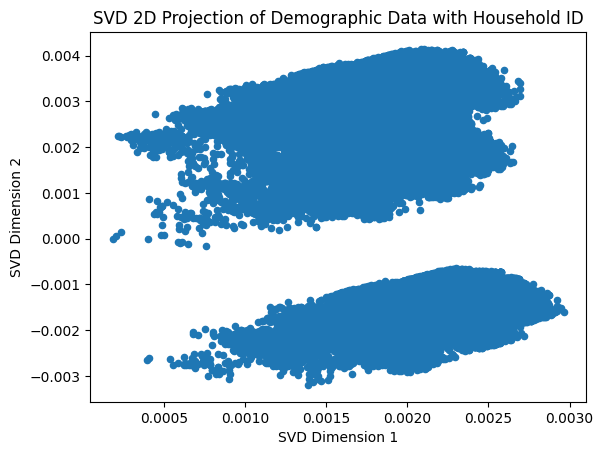

In [0]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import matplotlib.pyplot as plt

# Step 1: Convert the DataFrame into an RDD of (household_id, Vectors) tuples for MLlib
rows_rdd = demo_vec_df.select("household_id", "features_vec").rdd \
    .map(lambda row: (row['household_id'], Vectors.dense(row['features_vec'].toArray())))

# Step 2: Perform SVD with k=2 on the RowMatrix
vec_rdd = rows_rdd.map(lambda row: row[1])  # Extract just the Vectors for RowMatrix
svd = RowMatrix(vec_rdd).computeSVD(2, computeU=True)

# Step 3: Convert the U matrix (left singular vectors) to an RDD and zip it with household_id
household_id_rdd = rows_rdd.map(lambda row: row[0])  # Extract household_id
U_rdd = svd.U.rows.zip(household_id_rdd)  # Zip U matrix with household_id

# Step 4: Convert the RDD to a Spark DataFrame with household_id, x, and y
U_df = U_rdd.map(lambda row: (row[1], float(row[0][0]), float(row[0][1]))).toDF(["household_id", "x", "y"])
U_df.show(10, truncate=False)

# Step 5: Plot the result using toPandas() directly in the scatter plot command
U_df.toPandas().plot.scatter(x='x', y='y')
plt.title('SVD 2D Projection of Demographic Data with Household ID')
plt.xlabel('SVD Dimension 1')
plt.ylabel('SVD Dimension 2')
plt.show()

## Clustering

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import vector_to_array

# Step 1: Apply KMeans with k=8 and seed=7 and Get the cluster assignments (i.e., which cluster each household_id belongs to)
kmeans = KMeans().setK(8).setSeed(7).setFeaturesCol("features_vec").setPredictionCol("cluster")
model = kmeans.fit(demo_vec_df)
clustered_df = model.transform(demo_vec_df)

# Step 2: Calculate the distance between each household_id and its cluster's centroid
# Retrieve centroids from the KMeans model
centroids = model.clusterCenters()
centroid_df = spark.createDataFrame([(i, Vectors.dense(centroids[i])) for i in range(len(centroids))], ["cluster", "centroid"])

# Step 3: Join centroid_df to the clustered_df based on the cluster assignment
clustered_with_centroids = clustered_df.join(centroid_df, on="cluster") \
    .withColumn("features_vec", vector_to_array(f.col("features_vec"))) \
    .withColumn("centroid", vector_to_array(f.col("centroid")))

# Step 4: Calculate the Euclidean distance 
distance_df = clustered_with_centroids.withColumn("distance_from_centroid", 
        f.sqrt(sum(f.pow(f.col("features_vec")[i] - f.col("centroid")[i], 2) for i in range(len(centroids[0])))))

distance_df.select("household_id", "cluster", "distance_from_centroid").show(10, truncate=False)


+------------+-------+----------------------+
|household_id|cluster|distance_from_centroid|
+------------+-------+----------------------+
|04687893    |0      |0.7251426819214365    |
|04687884    |0      |0.6461631632201789    |
|04687827    |0      |1.0681329555561345    |
|04687748    |0      |0.8072628585940014    |
|04687639    |0      |0.611150671936939     |
|04687587    |0      |0.7837635774727431    |
|04687568    |0      |0.5836077058642958    |
|04687553    |0      |0.5333075388389821    |
|04687468    |0      |0.6203047941864769    |
|04687346    |0      |1.1353436910508998    |
+------------+-------+----------------------+
only showing top 10 rows



## Visual Clustering

+------------+-------+------------------------------------------+
|household_id|cluster|pca_features                              |
+------------+-------+------------------------------------------+
|00000015    |2      |[0.288131378090562,0.9958620783545068]    |
|00000028    |7      |[0.184399161891794,1.0324235165319482]    |
|00000056    |7      |[0.25848612000372806,1.0280513115368464]  |
|00000061    |5      |[-1.2255110792896233,0.9706140726906671]  |
|00000098    |3      |[-1.089506995918703,0.0020505524129435238]|
|00000111    |7      |[0.15346456378502282,1.0106084265978112]  |
|00000122    |3      |[-1.12044318621962,-0.009796392133612365] |
|00000130    |7      |[0.15217014732234632,1.0255308266001213]  |
|00000145    |6      |[-0.23800234905484963,1.0503897954507133] |
|00000160    |6      |[-0.22219933387665547,1.1473280873797005] |
+------------+-------+------------------------------------------+
only showing top 10 rows



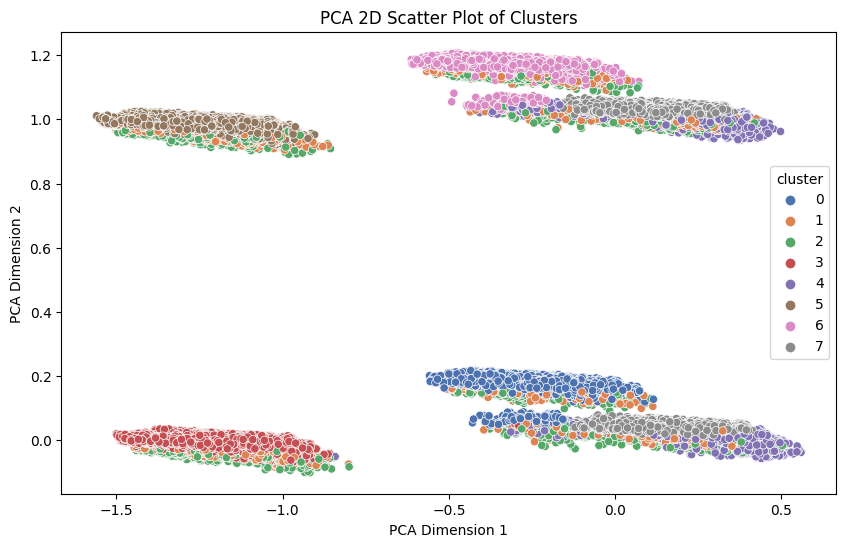

In [0]:
from pyspark.ml.feature import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Apply PCA to reduce the dimension of features_vec to 2
pca = PCA(k=2, inputCol="features_vec", outputCol="pca_features")
model = pca.fit(clustered_df)
pca_df = model.transform(clustered_df)

pca_df.select("household_id", "cluster", "pca_features").show(10, truncate=False)

# Step 2: Convert the PCA features (vector) to an array using vector_to_array and Extract the PCA components as separate columns (pca_x and pca_y)
pca_df = pca_df.withColumn("pca_array", vector_to_array(f.col("pca_features"))) \
        .withColumn("x", f.col("pca_array")[0]) \
        .withColumn("y", f.col("pca_array")[1])


# Step 3: Plot the data points with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df.select("x", "y", "cluster").toPandas(), x="x", y="y", hue="cluster", palette="deep")
plt.title("PCA 2D Scatter Plot of Clusters")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

## Dividing households into subsets

In [0]:
from pyspark.sql import Window

distance_df = distance_df.select("household_id", "cluster", "distance_from_centroid")

# Define the window specification
window_cluster = Window.partitionBy("cluster").orderBy("distance_from_centroid")

# Add a row number for ordering within each cluster
distance_df = distance_df.withColumn("row_number_in_cluster", f.row_number().over(window_cluster))

subsets_dict = {}

# Iterate over clusters 0-7 and create subsets
for cluster in range(8):
    # Filter data for the current cluster and create the full, 7ths, and 11ths subsets
    cluster_data = distance_df.filter(f.col("cluster") == cluster)
    subsets_dict[f'cluster_{cluster}_full'] = cluster_data
    subsets_dict[f'cluster_{cluster}_7ths'] = cluster_data.filter(f.col("row_number_in_cluster") % 7 == 0)
    subsets_dict[f'cluster_{cluster}_11ths'] = cluster_data.filter(f.col("row_number_in_cluster") % 11 == 0)


## Cluster’s Viewing Analysis

In [0]:
from pyspark.sql.functions import lpad

# Pad household_id in viewing_df with leading zeros to ensure 8 digits
static_viewing_df = static_viewing_df.withColumn("household_id", lpad(f.col("household_id").cast("string"), 8, '0'))

# Step 1: Aggregate viewing data by station for each subset
for subset_name, subset_df in subsets_dict.items():
    subset_viewing_counts = static_viewing_df.join(subset_df, "household_id") \
        .groupBy("station_num").count() \
        .withColumnRenamed("count", "view_count")
    
    total_view_count = subset_viewing_counts.agg(f.sum("view_count")).first()[0]
    
    # Step 2: Calculate the popularity rating per station for this subset
    subset_popularity = subset_viewing_counts.withColumn("popularity", 
        (f.col("view_count") / total_view_count) * 100)

    subsets_dict[subset_name] = subset_popularity.withColumnRenamed("popularity", "subset_popularity")

# Step 3: Calculate the popularity ratings for the entire dataset
general_viewing_counts = static_viewing_df.groupBy("station_num").count() \
    .withColumnRenamed("count", "view_count")

total_general_views = general_viewing_counts.agg(f.sum("view_count")).first()[0]

general_popularity = general_viewing_counts.withColumn("popularity", 
    (f.col("view_count") / total_general_views) * 100) \
    .select("station_num", f.col("popularity").alias("general_popularity"))

# Step 4: Calculate the diff rank for each station in each subset
results = []

for subset_name, subset_popularity in subsets_dict.items():
    diff_rank_df = subset_popularity.join(general_popularity, "station_num", "left") \
        .withColumn("diff_rank", f.col("subset_popularity") - f.col("general_popularity"))
    
    # Step 5: Select the top 10 stations with the highest diff rank
    top_10_diff_rank = diff_rank_df.orderBy(f.col("diff_rank").desc()).limit(10)
    results.append((subset_name, top_10_diff_rank))

for subset_name, top_10_diff_rank in results:
    print(f"Top 10 stations for {subset_name}:")
    top_10_diff_rank.show(truncate=False)

Top 10 stations for cluster_0_full:
+-----------+----------+-------------------+-------------------+--------------------+
|station_num|view_count|subset_popularity  |general_popularity |diff_rank           |
+-----------+----------+-------------------+-------------------+--------------------+
|60179      |6372      |1.6455166643424908 |1.3565135609316814 |0.28900310341080937 |
|99995      |4721      |1.2191594746329093 |1.022098515736489  |0.19706095889642028 |
|49788      |3812      |0.9844176905953507 |0.8238808426808082 |0.16053684791454248 |
|14902      |4078      |1.0531100058362644 |0.9034191584171588 |0.14969084741910554 |
|11713      |1796      |0.4638022487694779 |0.3683728909759275 |0.09542935779355038 |
|59684      |2133      |0.55082973086041   |0.4568532086306541 |0.09397652222975589 |
|19628      |765       |0.19755496676428205|0.11328843802119433|0.08426652874308772 |
|32645      |5242      |1.353703445461917  |1.2791810708897975 |0.07452237457211952 |
|50747      |1864 

# Dynamic Data Analysis - Streaming

In [0]:
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data" 
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(f.from_csv(f.decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")

viewing_counts = streaming_df.groupBy("event_date").count()
count_viewing_query =viewing_counts.writeStream\
.queryName('num_viewing')\
.format("memory")\
.outputMode("complete")\
.start()

time.sleep(20)

for i in range(10):
    print("Batch number: "+str(i))
    print(count_viewing_query.status)
    spark.sql('SELECT * FROM num_viewing').show()
    time.sleep(5)
    
count_viewing_query.stop()

Batch number: 0
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|12582|
|  20151004|18896|
|  20151018|18522|
+----------+-----+

Batch number: 1
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|12582|
|  20151004|18896|
|  20151018|18522|
+----------+-----+

Batch number: 2
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|30085|
|  20151004|35537|
|  20151018|34378|
+----------+-----+

Batch number: 3
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|47186|
|  20151004|52316|
|  20151018|50498|
+----------+-----+

Batch number: 4
{'message': 'Processing new data', 'isDataAv

In [0]:
from pyspark.sql.functions import col, sum as _sum

subsets_dict = {}
for cluster in range(8):
    # Filter data for the current cluster and create the 7ths subset
    cluster_data = distance_df.filter(col("cluster") == cluster)
    subsets_dict[f'cluster_{cluster}_7ths'] = cluster_data.filter(col("row_number_in_cluster") % 7 == 0)

# Pad household_id with leading zeros to ensure 8 digits
streaming_df = streaming_df.withColumn("household_id", lpad(col("household_id").cast("string"), 8, '0'))

# Define the streaming query
viewing_data_by_cluster_query = streaming_df \
    .writeStream \
    .queryName("viewing_data_by_cluster") \
    .format("memory") \
    .outputMode("append") \
    .start()

time.sleep(20)

# Initialize cumulative aggregates
cumulative_viewing_counts = None

min_batches = 3
for i in range(min_batches):
    print(f"Processing Batch number: {i}")
    
    # Retrieve the current batch from the in-memory table
    batch_data = spark.sql('SELECT * FROM viewing_data_by_cluster')
    batch_data = batch_data.withColumnRenamed("station_num", "batch_station_num").cache()

    # Calculate popularity and diff_rank for the 7th subset
    for cluster in range(8):
        subset_df = subsets_dict[f'cluster_{cluster}_7ths']
        
        subset_viewing_counts = subset_df.join(batch_data, "household_id") \
            .groupBy("batch_station_num").count() \
            .withColumnRenamed("count", "view_count")
        
        # If this is the first batch, initialize cumulative counts
        if cumulative_viewing_counts is None:
            cumulative_viewing_counts = subset_viewing_counts
        else:
            # Update cumulative view counts with the new batch's counts
            cumulative_viewing_counts = cumulative_viewing_counts.union(subset_viewing_counts) \
                .groupBy("batch_station_num") \
                .agg(_sum("view_count").alias("view_count"))
        
        total_view_count = cumulative_viewing_counts.agg(_sum("view_count")).first()[0]
        
        cumulative_popularity = cumulative_viewing_counts.withColumn("popularity", 
            (col("view_count") / total_view_count) * 100)
        
        cumulative_popularity = cumulative_popularity.select("batch_station_num", col("popularity").alias("subset_popularity"))
        
        diff_rank_df = cumulative_popularity.join(general_popularity, cumulative_popularity["batch_station_num"] == general_popularity["station_num"], "left") \
            .withColumn("diff_rank", col("subset_popularity") - col("general_popularity")) \
            .select("batch_station_num", "subset_popularity", "general_popularity", "diff_rank") \
            .withColumnRenamed("batch_station_num", "station_num")
        
        top_10_diff_rank = diff_rank_df.orderBy(col("diff_rank").desc()).limit(10)
        print(f"Top 10 stations for cluster {cluster} up to batch {i}:")
        top_10_diff_rank.show(truncate=False)

    time.sleep(5)

viewing_data_by_cluster_query.stop()

Processing Batch number: 0
Top 10 stations for cluster 0 up to batch 0:
+-----------+------------------+--------------------+------------------+
|station_num|subset_popularity |general_popularity  |diff_rank         |
+-----------+------------------+--------------------+------------------+
|99993      |11.158368776582437|7.915264244564543   |3.2431045320178935|
|11979      |3.0773079809857395|0.01610351672911066 |3.0612044642566287|
|11864      |2.902176632474356 |0.054077350097081055|2.848099282377275 |
|32494      |2.777082812109082 |0.015114357224865533|2.7619684548842165|
|99995      |3.752814610958219 |1.022098515736489   |2.73071609522173  |
|34429      |2.301726294721041 |0.03220703345822132 |2.2695192612628197|
|11565      |1.9514635976982737|0.05352342077470379 |1.89794017692357  |
|19580      |1.5011258443832876|0.022651752647213395|1.4784740917360741|
|10404      |1.4010507880910683|0.0277657072841607  |1.3732850808069077|
|14902      |2.251688766574931 |0.9034191584171588  